In [51]:
import math
import numpy as np
import pandas as pd
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import matplotlib.pyplot as plt

### Data collection

In [14]:
from google.colab import files

uploaded = files.upload()

Saving bitcoin2018-nov2021binance.csv to bitcoin2018-nov2021binance.csv


In [94]:
df = pd.read_csv('/content/bitcoin2018-nov2021binance.csv')
df.head()

,open,high,low,close,volume,period
0,13715.65,13818.55,12750.00,13380.00,8609.915844,1514764800000
1,13382.16,15473.49,12890.02,14675.11,20078.092111,1514851200000
2,14690.00,15307.56,14150.00,14919.51,15905.667639,1514937600000
3,14919.51,15280.00,13918.04,15059.54,21329.649574,1515024000000
4,15059.56,17176.24,14600.00,16960.39,23251.491125,1515110400000


In [33]:
time = []
def convert_int_timestamp():
    for i in df['period']:
        time.append(dt.datetime.fromtimestamp(i / 1e3))

convert_int_timestamp()

In [34]:
time[:10]

[datetime.datetime(2018, 1, 1, 0, 0),
 datetime.datetime(2018, 1, 2, 0, 0),
 datetime.datetime(2018, 1, 3, 0, 0),
 datetime.datetime(2018, 1, 4, 0, 0),
 datetime.datetime(2018, 1, 5, 0, 0),
 datetime.datetime(2018, 1, 6, 0, 0),
 datetime.datetime(2018, 1, 7, 0, 0),
 datetime.datetime(2018, 1, 8, 0, 0),
 datetime.datetime(2018, 1, 9, 0, 0),
 datetime.datetime(2018, 1, 10, 0, 0)]

In [47]:
df['date'] = pd.to_datetime(df['period'], unit='ms')

In [48]:
df.head()

,open,high,low,close,volume,period,date
0,13715.65,13818.55,12750.00,13380.00,8609.915844,1514764800000,2018-01-01
1,13382.16,15473.49,12890.02,14675.11,20078.092111,1514851200000,2018-01-02
2,14690.00,15307.56,14150.00,14919.51,15905.667639,1514937600000,2018-01-03
3,14919.51,15280.00,13918.04,15059.54,21329.649574,1515024000000,2018-01-04
4,15059.56,17176.24,14600.00,16960.39,23251.491125,1515110400000,2018-01-05


In [49]:
df1 = df.reset_index()['close']

df1

0       13380.00
1       14675.11
2       14919.51
3       15059.54
4       16960.39
          ...   
1380    60575.89
1381    62253.71
1382    61691.33
1383    61299.80
1384    60911.11
Name: close, Length: 1385, dtype: float64

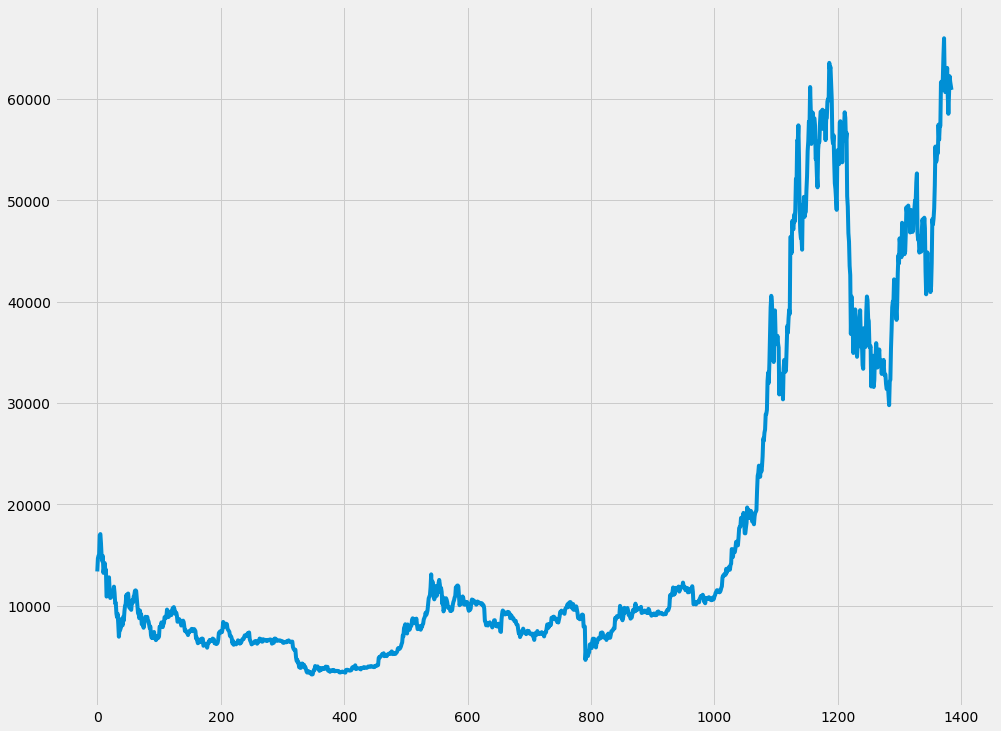

In [53]:
plt.figure(figsize=(15,12))
plt.plot(df1)

In [54]:
scaler = MinMaxScaler(feature_range=(0, 1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1, 1))

In [55]:
print(df1)

[[0.16194187]
 [0.18256803]
 [0.18646039]
 ...
 [0.93135688]
 [0.92512131]
 [0.91893096]]


In [56]:
# Spitting dataset into train and test split

training_size = int(len(df1)*0.80)

test_size = len(df1) - training_size
train_data, test_data = df1[0:training_size, : ], df1[training_size: len(df1), : 1]

In [57]:
len(train_data), len(test_data)

(1108, 277)

In [58]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i: (i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])

    return np.array(dataX), np.array(dataY)

In [59]:
time_step = 15
X_train, y_train = create_dataset(train_data, time_step)

In [60]:
print(X_train.shape), print(y_train.shape)

(1092, 15)
(1092,)


(None, None)

In [61]:
X_test, y_test = create_dataset(test_data, time_step)
print(X_test.shape), print(y_test.shape)

(261, 15)
(261,)


(None, None)

In [64]:
# reshape the inputs to be [sample, time_steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_train.shape

(1092, 15, 1)

In [66]:
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
X_test.shape

(261, 15, 1)

In [70]:
model_0 = Sequential()
model_0.add(LSTM(50, return_sequences=True, input_shape=(time_step,1)))
model_0.add(LSTM(50, return_sequences=True))
model_0.add(LSTM(50))
model_0.add(Dense(1))


model_0.compile(optimizer='adam', loss='mean_squared_error')

In [71]:
model_0.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 15, 50)            10400     
                                                                 
 lstm_4 (LSTM)               (None, 15, 50)            20200     
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [72]:
history = model_0.fit(X_train, y_train, epochs=100, batch_size=64)

Epoch 1/100
18/18 [==============================] - 12s 58ms/step - loss: 0.0056
Epoch 2/100
18/18 [==============================] - 1s 62ms/step - loss: 6.6243e-04
Epoch 3/100
18/18 [==============================] - 1s 57ms/step - loss: 4.4556e-04
Epoch 4/100
18/18 [==============================] - 1s 58ms/step - loss: 8.0428e-04
Epoch 5/100
18/18 [==============================] - 1s 61ms/step - loss: 5.1413e-04
Epoch 6/100
18/18 [==============================] - 1s 61ms/step - loss: 4.4666e-04
Epoch 7/100
18/18 [==============================] - 1s 60ms/step - loss: 4.1861e-04
Epoch 8/100
18/18 [==============================] - 1s 63ms/step - loss: 3.8062e-04
Epoch 9/100
18/18 [==============================] - 1s 62ms/step - loss: 3.7860e-04
Epoch 10/100
18/18 [==============================] - 1s 60ms/step - loss: 3.6301e-04
Epoch 11/100
18/18 [==============================] - 1s 55ms/step - loss: 3.5538e-04
Epoch 12/100
18/18 [==============================] - 1s 61ms/step

In [74]:
train_predict = model_0.predict(X_train)
test_predict = model_0.predict(X_test)

In [89]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [90]:
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train, train_predict))

10390.782498227823

In [91]:
math.sqrt(mean_squared_error(y_test, test_predict))

38317.85853867072

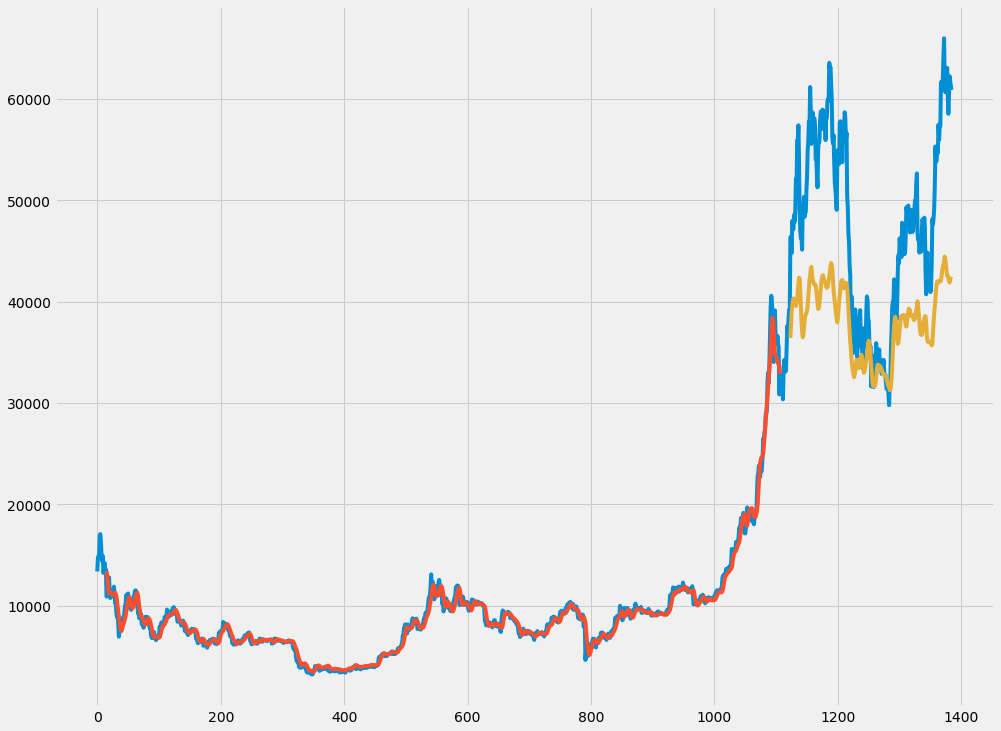

In [93]:
# shift train predictions for plotting
look_back = 15
plt.figure(figsize=(15,12))
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back: len(train_predict) + look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()